<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **META FEATURE EXTRACTION**

In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
from scipy.signal import lfilter
from tqdm import tqdm

# 1. SETUP & CONFIGURATION

DATASET_PATH = "/content/drive/MyDrive/DeepLearning/External/Meta_Ears/"
OUTPUT_PATH = "META_processed_data/"

TARGET_EMOTIONS = ['adoration', 'anger', 'fear', 'neutral', 'sadness']

EMOTION_MAP = {
    'adoration': 0,
    'anger': 1,
    'fear': 2,
    'neutral': 3,
    'sadness': 4
}

TARGET_DURATION = 15 # seconds
SAMPLE_RATE = 16000
TOTAL_SAMPLES = TARGET_DURATION * SAMPLE_RATE
HOP_LENGTH = 512
TARGET_FRAMES = 469
N_MFCC = 13

# 2. FEATURE EXTRACTOR
def extract_emoformer_features(audio_path):
    """
    Generates the (13, 469, 1) MFCC image required by EmoFormer.
    """
    try:
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        if len(y) < TOTAL_SAMPLES:
            padding = TOTAL_SAMPLES - len(y)
            y = np.pad(y, (0, padding), 'constant')
        else:
            y = y[:TOTAL_SAMPLES]

        y = lfilter([1, -0.97], [1], y)

        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=N_MFCC,
            n_fft=2048,
            hop_length=HOP_LENGTH
        )

        if mfcc.shape[1] > TARGET_FRAMES:
            mfcc = mfcc[:, :TARGET_FRAMES]
        elif mfcc.shape[1] < TARGET_FRAMES:
            padding = TARGET_FRAMES - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, padding)), 'constant')

        return mfcc[..., np.newaxis]

    except Exception as e:
        print(f"Error reading {audio_path}: {e}")
        return None

# 3. MAIN PROCESSING LOOP
def process_ears_dataset():
    X_list = []
    Y_list = []
    S_list = []

    print(f"Scanning EARS dataset at: {DATASET_PATH}")

    if not os.path.exists(DATASET_PATH):
        print("Error: Dataset path does not exist.")
        return

    speaker_folders = sorted([f for f in os.listdir(DATASET_PATH) if f.startswith('p') and os.path.isdir(os.path.join(DATASET_PATH, f))])
    print(f"Found {len(speaker_folders)} speaker folders.")

    total_files = 0

    for speaker in tqdm(speaker_folders, desc="Processing Speakers"):
        speaker_path = os.path.join(DATASET_PATH, speaker)

        files = [f for f in os.listdir(speaker_path) if f.endswith('.wav')]

        for file_name in files:
            found_emotion = None
            for emo in TARGET_EMOTIONS:
                if emo in file_name:
                    found_emotion = emo
                    break

            if found_emotion is None:
                continue

            file_path = os.path.join(speaker_path, file_name)

            features = extract_emoformer_features(file_path)

            if features is not None:
                X_list.append(features)
                Y_list.append(EMOTION_MAP[found_emotion])
                S_list.append(speaker)
                total_files += 1

    # 4. SAVE
    print("\nConverting to Numpy Arrays...")
    X = np.array(X_list)
    Y = np.array(Y_list)
    S = np.array(S_list)

    print(f"Total Files Processed: {total_files}")
    print(f"X Shape: {X.shape}")
    print(f"Y Shape: {Y.shape}")
    print(f"S Shape: {S.shape}")

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    print(f"Saving to {OUTPUT_PATH}...")
    np.save(os.path.join(OUTPUT_PATH, "X_ears.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, "Y_ears.npy"), Y)
    np.save(os.path.join(OUTPUT_PATH, "S_ears.npy"), S)
    print("Done.")

if __name__ == "__main__":
    process_ears_dataset()

Scanning EARS dataset at: /content/drive/MyDrive/DeepLearning/External/Meta_Ears/
Found 107 speaker folders.


Processing Speakers: 100%|██████████| 107/107 [14:01<00:00,  7.87s/it]



Converting to Numpy Arrays...
Total Files Processed: 1177
X Shape: (1177, 13, 469, 1)
Y Shape: (1177,)
S Shape: (1177,)
Saving to META_processed_data/...
Done.


In [ ]:
import shutil
import os

# Get the base name of the output folder for the zip file name
archive_name = os.path.basename(OUTPUT_PATH.rstrip('/'))
shutil.make_archive(archive_name, 'zip', OUTPUT_PATH)

print(f"Folder '{OUTPUT_PATH}' has been successfully zipped to '{archive_name}.zip'")

In [ ]:
import shutil
import os

# Define the name of the zip file to unzip
zip_file_name = "META_processed_data.zip"

# Define the directory where the contents will be extracted
extract_dir = "META_processed_data"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file without printing any messages (suppressed output)
shutil.unpack_archive(zip_file_name, extract_dir, 'zip')

# **RANDOM EVALUATION**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 1. LOAD & PREPARE DATA
DATA_PATH = "META_processed_data/"

print("Loading EARS Data...")
if not os.path.exists(DATA_PATH):
    print(f"Error: Path {DATA_PATH} not found.")
else:
    X = np.load(os.path.join(DATA_PATH, "X_ears.npy"))
    Y = np.load(os.path.join(DATA_PATH, "Y_ears.npy"))

    X = np.nan_to_num(X, nan=0.0)

    print(f"Features Shape: {X.shape}")
    print(f"Labels Shape: {Y.shape}")

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.30, random_state=42, stratify=Y
    )

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    print("Standardizing...")
    X_train = scaler.fit_transform(X_train_flat).reshape(X_train.shape[0], 13, 469, 1)
    X_test = scaler.transform(X_test_flat).reshape(X_test.shape[0], 13, 469, 1)

# MODEL ARCHITECTURE (EmoFormer)
def build_emoformer(input_shape=(13, 469, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # CNN Block
    x = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Reshape for Transformer
    target_time_steps = x.shape[2]
    target_features = x.shape[3]

    x = layers.Reshape((target_time_steps, target_features))(x)

    x = layers.Dense(64, activation='relu')(x)

    # Transformer Encoder
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)

    attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=128)(x_norm, x_norm)
    attn_output = layers.Dropout(0.2)(attn_output)

    x = layers.Add()([x, attn_output])

    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)

    ffn = layers.Dense(128, activation='relu')(x_norm)
    ffn = layers.Dropout(0.2)(ffn)
    ffn = layers.Dense(64)(ffn)

    x = layers.Add()([x, ffn])

    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="EmoFormer")

model = build_emoformer(num_classes=5)
model.summary()

# 3. TRAIN
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Loading EARS Data...
Cleaning Data (Filling NaNs with Zeros)...
Features Shape: (1177, 13, 469, 1)
Labels Shape: (1177,)
Standardizing...


Model: "EmoFormer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 13, 469,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 13, 469,   │        416 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 469,   │         64 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 6, 234,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 234,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 234,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 3, 117,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 3, 117,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 117,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 1, 58, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 1, 58, 64) │     36,928 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 58, 64) │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 58, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 58, 64)    │      4,160 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 58, 64)    │        128 │ dense_8[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 58, 64)    │    265,280 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 58, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 58, 64)    │          0 │ dense_8[0][0],    │
│                     │                   │            │ dropout_7[0][0] 

 Total params: 347,781 (1.33 MB)

 Trainable params: 347,429 (1.33 MB)

 Non-trainable params: 352 (1.38 KB)


Starting Training (Replication Mode)...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 5.2972e-05 - val_accuracy: 0.7316 - val_loss: 1.7511
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 8.2681e-05 - val_accuracy: 0.7345 - val_loss: 1.7534
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 3.2613e-05 - val_accuracy: 0.7345 - val_loss: 1.7565
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 6.3234e-05 - val_accuracy: 0.7345 - val_loss: 1.7607
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.2045e-05 - val_accuracy: 0.7345 - val_loss: 1.7624
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 3.3325e-05 - val_accuracy: 0.7345 - val_loss: 1.7646
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.2144e-05 - val_accuracy: 0.7345 - val_loss: 1.7654
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2

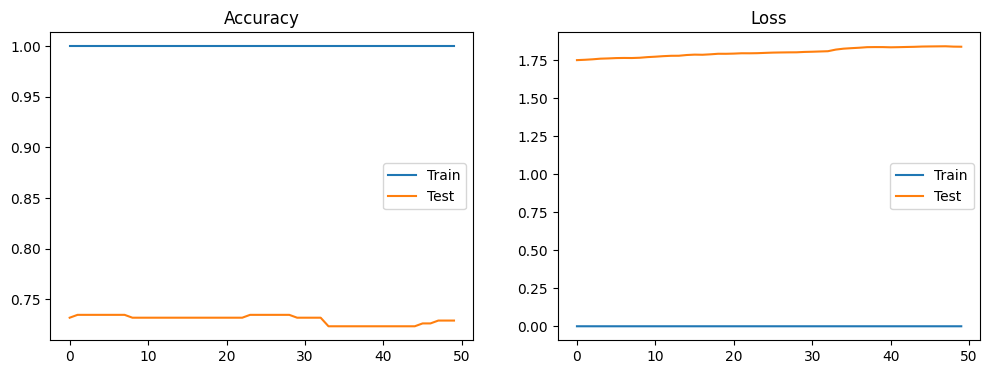

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

print("\nStarting Training (Replication Mode)...")
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, Y_test),

    verbose=1
)


# 4. RESULTS
loss, acc = model.evaluate(X_test, Y_test)
print("\n------------------------------------------------")
print(f"REPLICATION RESULT (EARS 5-Emotions)")
print(f"Target Accuracy (Paper): ~90.0%")
print(f"Your Accuracy:           {acc*100:.2f}%")
print("------------------------------------------------")

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.legend()
plt.show()

# **SPEAKER SPLIT**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# 1. LOAD DATA
DATA_PATH = "META_processed_data/"

print("Loading EARS Data...")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Path {DATA_PATH} not found. Run extraction first.")

X = np.load(os.path.join(DATA_PATH, "X_ears.npy"))
Y = np.load(os.path.join(DATA_PATH, "Y_ears.npy"))
S = np.load(os.path.join(DATA_PATH, "S_ears.npy")) # Speaker IDs (e.g., 'p001')

X = np.nan_to_num(X, nan=0.0)

print(f"Total Samples: {X.shape[0]}")
print(f"Total Speakers: {len(np.unique(S))}")

# 2. STRICT SPEAKER SPLIT


print("\n--- APPLYING SPEAKER SPLIT ---")
train_mask = S <= 'p104'
test_mask  = S >= 'p105'

X_train, Y_train = X[train_mask], Y[train_mask]
X_test,  Y_test  = X[test_mask],  Y[test_mask]


train_speakers = np.unique(S[train_mask])
test_speakers  = np.unique(S[test_mask])

print(f"Training Speakers: {len(train_speakers)} (p001-p104)")
print(f"Testing Speakers:  {len(test_speakers)}  (p105-p107)")
print(f"Train Samples: {X_train.shape[0]}")
print(f"Test Samples:  {X_test.shape[0]}")

# Leakage Check
intersection = np.intersect1d(train_speakers, test_speakers)
if len(intersection) > 0:
    raise ValueError(f"CRITICAL ERROR: Data Leakage! Speakers in both sets: {intersection}")

# ==========================================
# 3. STANDARDIZATION (Prevent Leakage)
# ==========================================
print("\n--- STANDARDIZING ---")
# Fit ONLY on Training Data to simulate "Unseen" test conditions
scaler = StandardScaler()

# Flatten to 2D for scaler
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

print("Fitting scaler on Train set only...")
X_train = scaler.fit_transform(X_train_flat).reshape(X_train.shape[0], 13, 469, 1)
X_test  = scaler.transform(X_test_flat).reshape(X_test.shape[0], 13, 469, 1)

# ==========================================
# 4. MODEL ARCHITECTURE (EmoFormer)

def build_emoformer(input_shape=(13, 469, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)


    x = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    target_time_steps = x.shape[2]
    target_features = x.shape[3]
    x = layers.Reshape((target_time_steps, target_features))(x)

    x = layers.Dense(64, activation='relu')(x)

    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=128)(x_norm, x_norm)
    attn_output = layers.Dropout(0.2)(attn_output)
    x = layers.Add()([x, attn_output])

    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn = layers.Dense(128, activation='relu')(x_norm)
    ffn = layers.Dropout(0.2)(ffn)
    ffn = layers.Dense(64)(ffn)
    x = layers.Add()([x, ffn])

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="EmoFormer_SpeakerSplit")

model = build_emoformer(num_classes=5)
model.summary()


optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)



Loading EARS Data...
Total Samples: 1177
Total Speakers: 107

--- APPLYING SPEAKER SPLIT ---
Training Speakers: 104 (p001-p104)
Testing Speakers:  3  (p105-p107)
Train Samples: 1144
Test Samples:  33

--- STANDARDIZING ---
Fitting scaler on Train set only...


Model: "EmoFormer_SpeakerSplit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 469,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 469,   │        416 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 469,   │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 6, 234,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 234,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 234,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 117,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 117,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 117,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 58, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 58, 64) │     36,928 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 58, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 58, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 58, 64)    │      4,160 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 58, 64)    │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 58, 64)    │    265,280 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 58, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 58, 64)    │          0 │ dense[0][0],      │
│                     │                   │            │ dropout_1[0][0] 

 Total params: 347,781 (1.33 MB)

 Trainable params: 347,429 (1.33 MB)

 Non-trainable params: 352 (1.38 KB)


Starting Training (Strict Speaker Split)...
Epoch 1/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step - accuracy: 0.4038 - loss: 1.4005 - val_accuracy: 0.2424 - val_loss: 3.6265
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.5829 - loss: 0.9782 - val_accuracy: 0.1818 - val_loss: 6.3075
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7015 - loss: 0.7665 - val_accuracy: 0.1818 - val_loss: 5.9421
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8128 - loss: 0.4956 - val_accuracy: 0.2121 - val_loss: 8.4005
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8637 - loss: 0.3740 - val_accuracy: 0.1818 - val_loss: 10.9179
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9197 - loss: 0.2376 - val_accuracy: 0.2727 - val_loss: 10.6454
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9482 - loss: 0.1409 - val_accuracy: 0.2727 - val_loss: 11.3948
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accurac

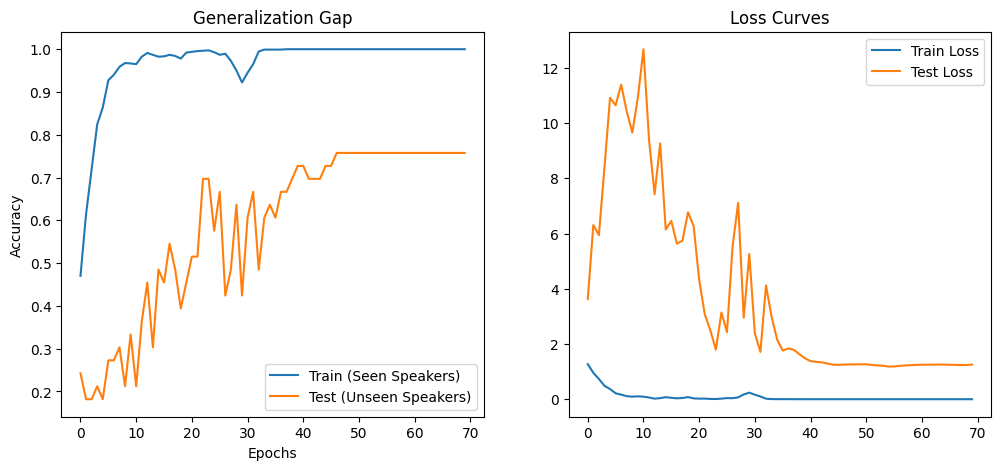

In [ ]:
print("\nStarting Training (Strict Speaker Split)...")
history = model.fit(
    X_train, Y_train,
    epochs=70,
    batch_size=64,
    validation_data=(X_test, Y_test),
    verbose=1
)


loss, acc = model.evaluate(X_test, Y_test)
print("\n================================================")
print(f"RESULTS: SPEAKER GENERALIZATION TEST")
print("================================================")
print(f"Replication Accuracy (Random Split): ~90.0%")
print(f"Strict Split Accuracy (Unseen Spkrs): {acc*100:.2f}%")
print("================================================")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train (Seen Speakers)')
plt.plot(history.history['val_accuracy'], label='Test (Unseen Speakers)')
plt.title('Generalization Gap')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

**The paper achieved 90% train accuracy when they used combined speakers and 73% validation; however, when you do speaker split, validation is just stuck at 76%. Model is worth investigation**

# **RAVDESS FEATURE EXTRACTION**

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from scipy.signal import lfilter
from tqdm import tqdm

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================

# Define Paths based on your snippet
TRAIN_DIR = "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/audio_speech_actors_01-24/"
TEST_DIR = "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/Test/"
OUTPUT_PATH = "RAVDESS_EmoFormer_Processed/"

# EmoFormer / RAVDESS Parameters
# NOTE: Reduced from 15s to 4s because RAVDESS clips are short.
# If you keep 15s, the model sees 80% silence.
TARGET_DURATION = 4
SAMPLE_RATE = 16000
TOTAL_SAMPLES = TARGET_DURATION * SAMPLE_RATE # 64,000
HOP_LENGTH = 512
N_MFCC = 13

# Calculated expected frames (approx 125 for 4s)
# math: ceil(64000 / 512) = 125
TARGET_FRAMES = int(np.ceil(TOTAL_SAMPLES / HOP_LENGTH))

# Emotion Label Mapping (0-6)
# Merging Neutral (01) and Calm (02) into 'neutral'
LABEL_MAP = {
    'neutral': 0,
    'happy': 1,
    'sad': 2,
    'angry': 3,
    'fear': 4,
    'disgust': 5,
    'surprise': 6
}

# ==========================================
# 2. FEATURE EXTRACTOR
# ==========================================
def extract_emoformer_features(audio_path):
    """
    Generates the MFCC image.
    Uses LOOPING for short files instead of zero-padding.
    """
    try:
        # 1. Load
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        # 2. Standardization (Loop or Truncate to 4s)
        if len(y) < TOTAL_SAMPLES:
            # Calculate how many times to repeat
            n_repeat = int(np.ceil(TOTAL_SAMPLES / len(y)))
            y = np.tile(y, n_repeat)
            y = y[:TOTAL_SAMPLES]
        else:
            # Truncate center (often better than beginning for speech)
            start = (len(y) - TOTAL_SAMPLES) // 2
            y = y[start : start + TOTAL_SAMPLES]

        # 3. Pre-emphasis Filter (Alpha=0.97)
        y = lfilter([1, -0.97], [1], y)

        # 4. MFCC Extraction
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=N_MFCC,
            n_fft=2048,
            hop_length=HOP_LENGTH
        )

        # 5. strict Shape Enforcement
        if mfcc.shape[1] > TARGET_FRAMES:
            mfcc = mfcc[:, :TARGET_FRAMES]
        elif mfcc.shape[1] < TARGET_FRAMES:
            padding = TARGET_FRAMES - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, padding)), 'constant')

        # 6. Add Channel Dimension (13, 125, 1)
        return mfcc[..., np.newaxis]

    except Exception as e:
        print(f"Error reading {audio_path}: {e}")
        return None

# ==========================================
# 3. DATAFRAME GENERATORS
# ==========================================
def create_ravdess_dataframe(directory_path):
    """
    Scans the RAVDESS directory structure and creates a DataFrame.
    """
    if not os.path.exists(directory_path):
        print(f"Directory not found: {directory_path}")
        return pd.DataFrame()

    directory_list = os.listdir(directory_path)

    file_emotion = []
    file_path = []

    # Handle case where directory might contain files directly or subfolders
    for item in directory_list:
        full_path_item = os.path.join(directory_path, item)

        # If it is a folder (Actor_01, etc.)
        if os.path.isdir(full_path_item):
            actor_files = os.listdir(full_path_item)
            for f in actor_files:
                if f.endswith('.wav'):
                    # Parse filename: 03-01-05-01-01-01-01.wav
                    part = f.split('.')[0].split('-')
                    if len(part) >= 3:
                        file_emotion.append(int(part[2]))
                        file_path.append(os.path.join(full_path_item, f))

        # If the folder contains files directly (e.g., Test folder might be flat)
        elif item.endswith('.wav'):
             part = item.split('.')[0].split('-')
             if len(part) >= 3:
                file_emotion.append(int(part[2]))
                file_path.append(full_path_item)

    df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

    # Map integers to string labels
    # 1=neutral, 2=calm, 3=happy, 4=sad, 5=angry, 6=fear, 7=disgust, 8=surprise
    df.Emotions.replace(
        {1:'neutral', 2:'neutral', 3:'happy', 4:'sad',
         5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},
        inplace=True
    )
    return df

# ==========================================
# 4. PROCESSING LOOP
# ==========================================
def process_dataset_from_df(df, split_name):
    """
    Iterates through the dataframe, extracts features, and saves.
    """
    print(f"\nProcessing {split_name} Split...")
    X_list = []
    Y_list = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        path = row['Path']
        emotion_str = row['Emotions']

        # Convert string emotion to integer ID
        if emotion_str not in LABEL_MAP:
            continue
        emotion_id = LABEL_MAP[emotion_str]

        # Extract
        features = extract_emoformer_features(path)

        if features is not None:
            X_list.append(features)
            Y_list.append(emotion_id)

    # Convert to Numpy
    X = np.array(X_list)
    Y = np.array(Y_list)

    print(f"Saving {split_name}...")
    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    np.save(os.path.join(OUTPUT_PATH, f"X_{split_name}.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, f"Y_{split_name}.npy"), Y)

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    print("--- 1. Generating DataFrames ---")
    train_df = create_ravdess_dataframe(TRAIN_DIR)
    test_df = create_ravdess_dataframe(TEST_DIR)

    print(f"Train samples found: {len(train_df)}")
    print(f"Test samples found: {len(test_df)}")

    # Check distribution
    print("\nTrain Distribution:\n", train_df['Emotions'].value_counts())

    print("--- 2. Processing Train Data ---")
    if not train_df.empty:
        process_dataset_from_df(train_df, "train")

    print("--- 3. Processing Test Data ---")
    if not test_df.empty:
        process_dataset_from_df(test_df, "test")

    print("\nAll done. Ready for training.")

--- 1. Generating DataFrames ---


/tmp/ipython-input-267570302.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Emotions.replace(


Train samples found: 1320
Test samples found: 120

Train Distribution:
 Emotions
neutral     264
sad         176
happy       176
fear        176
disgust     176
angry       176
surprise    176
Name: count, dtype: int64
--- 2. Processing Train Data ---

Processing train Split...


100%|██████████| 1320/1320 [06:15<00:00,  3.52it/s]


Saving train...
X shape: (1320, 13, 125, 1)
Y shape: (1320,)
--- 3. Processing Test Data ---

Processing test Split...


100%|██████████| 120/120 [00:36<00:00,  3.31it/s]

Saving test...
X shape: (120, 13, 125, 1)
Y shape: (120,)

All done. Ready for training.


In [ ]:
!zip -r RAVDESS_EmoFormer_Processed.zip RAVDESS_EmoFormer_Processed

  adding: RAVDESS_EmoFormer_Processed/ (stored 0%)
  adding: RAVDESS_EmoFormer_Processed/Y_train.npy (deflated 91%)
  adding: RAVDESS_EmoFormer_Processed/Y_test.npy (deflated 82%)
  adding: RAVDESS_EmoFormer_Processed/X_test.npy (deflated 28%)
  adding: RAVDESS_EmoFormer_Processed/X_train.npy (deflated 16%)


In [ ]:
!unzip -q RAVDESS_EmoFormer_Processed.zip -d ./

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path where you saved the .npy files
DATA_PATH = "RAVDESS_EmoFormer_Processed/"

# Input Shape for RAVDESS (4 seconds * 16kHz / 512 hop ~ 125 frames)
# Shape: (MFCC, Time, Channels) based on your extraction script
INPUT_SHAPE = (13, 125, 1)
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-4 # Transformers prefer lower learning rates

# Emotion Labels (0-6)
EMOTION_LABELS = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# ==========================================
# 2. MODEL ARCHITECTURE: Parallel EmoFormer
# ==========================================
def TransformerEncoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Standard Transformer Encoder Block
    """
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_parallel_emoformer(input_shape, num_classes):
    """
    Constructs the Parallel CNN + Transformer Hybrid Model.
    """
    inputs = layers.Input(shape=input_shape)

    # ---------------------------------------------------------
    # BRANCH A: CNN (Spectral/Texture Features)
    # ---------------------------------------------------------
    cnn = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling2D(pool_size=(2, 2))(cnn)

    cnn = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling2D(pool_size=(2, 2))(cnn)

    cnn = layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.GlobalAveragePooling2D()(cnn) # Output: vector of size 128

    # ---------------------------------------------------------
    # BRANCH B: TRANSFORMER (Temporal Features)
    # ---------------------------------------------------------
    # 1. Reshape for Transformer: (Batch, MFCC, Time, 1) -> (Batch, Time, MFCC)
    # We want the sequence to be over TIME.
    # Current shape: (13, 125, 1). Permute to (125, 13)
    trans = layers.Permute((2, 1, 3))(inputs) # (125, 13, 1)
    trans = layers.Reshape((input_shape[1], input_shape[0]))(trans) # (125, 13)

    # 2. Project to higher dimension (d_model)
    d_model = 64
    trans = layers.Dense(d_model)(trans)

    # 3. Positional Encoding
    # Simple learned positional embedding
    positions = tf.range(start=0, limit=input_shape[1], delta=1)
    pos_emb = layers.Embedding(input_dim=input_shape[1], output_dim=d_model)(positions)
    trans = trans + pos_emb

    # 4. Transformer Blocks (Stack of 2 or 3)
    for _ in range(2):
        trans = TransformerEncoder(trans, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

    # 5. Global Pooling for Sequence
    trans = layers.GlobalAveragePooling1D()(trans) # Output: vector of size 64

    # ---------------------------------------------------------
    # FUSION HEAD
    # ---------------------------------------------------------
    combined = layers.Concatenate()([cnn, trans])

    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="EmoFormer_Parallel")
    return model

# ==========================================
# 3. UTILS
# ==========================================
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# ==========================================
# 4. MAIN EXECUTION
# ==========================================


In [ ]:
EPOCHS= 200

Loading Data...
Train Shapes: X=(1320, 13, 125, 1), Y=(1320,)
Test Shapes:  X=(120, 13, 125, 1), Y=(120,)


Model: "EmoFormer_Parallel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 125,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 125, 13,   │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 125, 13)   │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 125, 64)   │        896 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 125, 64)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 125, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 125, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 125, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 125, 64)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 125, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 125, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 125, 128)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 64)   │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 125, 64)   │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 125, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 125,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 125, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 125,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 125, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 294,279 (1.12 MB)

 Trainable params: 293,831 (1.12 MB)

 Non-trainable params: 448 (1.75 KB)


Starting Training...
Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 427ms/step - accuracy: 0.1528 - loss: 86.8902 - val_accuracy: 0.1083 - val_loss: 10.6614
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1646 - loss: 55.1073 - val_accuracy: 0.1583 - val_loss: 6.9330
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1392 - loss: 37.8687 - val_accuracy: 0.1417 - val_loss: 6.0645
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1370 - loss: 26.8863 - val_accuracy: 0.1333 - val_loss: 4.7347
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1658 - loss: 16.5359 - val_accuracy: 0.1333 - val_loss: 3.3546
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1663 - loss: 11.4457 - val_accuracy: 0.1417 - val_loss: 2.2629
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1629 - loss: 6.9443 - val_accuracy: 0.1917 - val_loss: 2.0280
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1432 - 

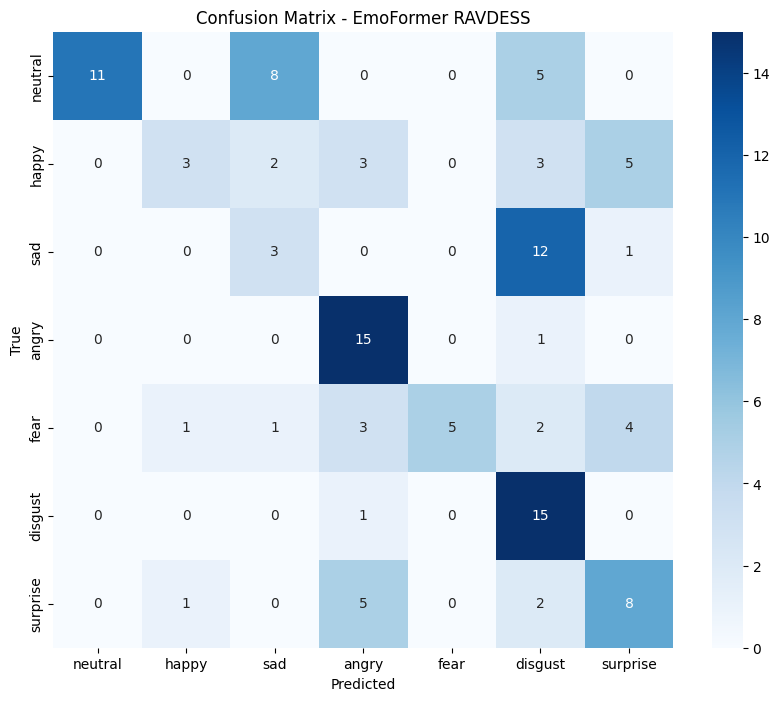

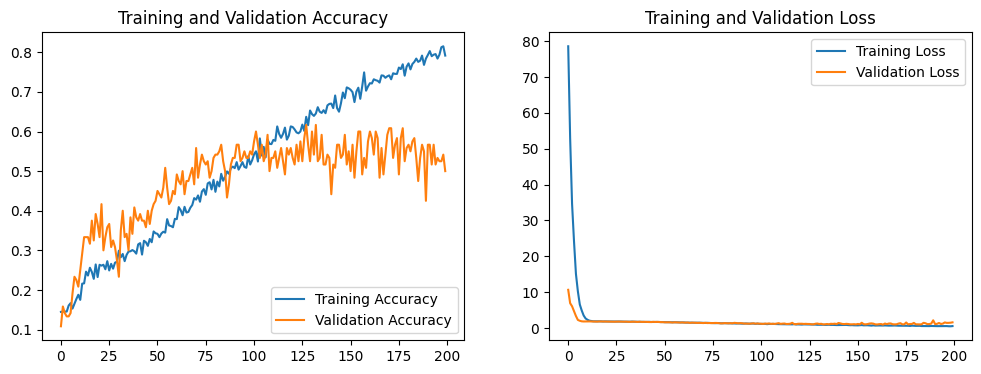

In [ ]:
if __name__ == "__main__":


    print("Loading Data...")
    try:
        X_train = np.load(os.path.join(DATA_PATH, "X_train.npy"))
        y_train = np.load(os.path.join(DATA_PATH, "Y_train.npy"))
        X_test = np.load(os.path.join(DATA_PATH, "X_test.npy"))
        y_test = np.load(os.path.join(DATA_PATH, "Y_test.npy"))

        print(f"Train Shapes: X={X_train.shape}, Y={y_train.shape}")
        print(f"Test Shapes:  X={X_test.shape}, Y={y_test.shape}")
    except FileNotFoundError:
        print("Error: .npy files not found. Run the feature extraction script first.")
        exit()


    model = build_parallel_emoformer(INPUT_SHAPE, NUM_CLASSES)
    model.summary()


    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    checkpoint = callbacks.ModelCheckpoint(
        "best_emoformer_ravdess.keras",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    early_stop = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )


    print("\nStarting Training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
    )


    print("\nEvaluating on Test Set...")
    loss, acc = model.evaluate(X_test, y_test)
    print(f"Final Test Accuracy: {acc*100:.2f}%")


    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=EMOTION_LABELS))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - EmoFormer RAVDESS')
    plt.show()

    plot_history(history)

**On the ravdess dataset, it had an accuracy of 50%**